In [101]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

In [122]:
llm = ChatOllama(model="llama3.2:latest", temperature=0)
employee_dep= {"manuf":"Manufacturing", "qc":"Quality control", "wh":"Warehouse", "hk":"Housekeeping", "gen":"General"}

In [134]:
def check_employee_department(emp_id: str):
    """Check the only employee Department with employee id
       Args:
          emp_id: first str
    """
    try:
        #dept=next(e_dep if eid in emp_id else f"{employee_dep["gen"]}" for eid, e_dep in employee_dep.items())
        result = ""
        for eid, e_dep in employee_dep.items():
            if eid in emp_id:
                result = e_dep
                break
    except Exception as e:
        return f"Error: {e}"

    if not result:
        result = f"{employee_dep["gen"]}"

    print(result)
    return result


llm_with_tools = llm.bind_tools([check_employee_department])

In [ ]:
msg = [HumanMessage(content="tell me some poem?")]
response  = [llm_with_tools.invoke(msg)]
print(response)
for msg in response:
    msg.pretty_print()

In [ ]:
class MsgState(MessagesState):
    pass

In [ ]:
def tool_calling(state:MsgState):
    return {"messages":llm_with_tools.invoke(state["messages"])}

In [ ]:
builder_sg = StateGraph(MsgState)
builder_sg.add_node("tool_call_llm",tool_calling)
builder_sg.add_edge(START, "tool_call_llm")
builder_sg.add_edge("tool_call_llm", END)

graph = builder_sg.compile()

In [ ]:
mg = {"messages":[HumanMessage(content="What is the department name of employee qc980")]}
resp=graph.invoke(mg)
op:list = resp["messages"]
for msg in op:
    msg.pretty_print()

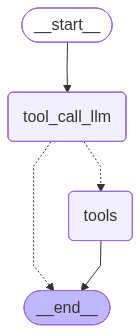

In [138]:
builder_sg = StateGraph(MsgState)
builder_sg.add_node("tool_call_llm", tool_calling)
builder_sg.add_node("tools", ToolNode([check_employee_department]))

builder_sg.add_edge(START, "tool_call_llm")
builder_sg.add_conditional_edges("tool_call_llm", tools_condition)
builder_sg.add_edge("tools", END)

graph = builder_sg.compile()
graph

In [146]:
mg = {"messages":[SystemMessage(content="You are the intelligent AI system invoke tools for the employee related things"), HumanMessage(content="explain the langchain")]}
mg1 = {"messages":[SystemMessage(content="You are the intelligent AI system invoke tools for the employee related things"), HumanMessage(content="what is the department for the employee id hk782")]}
resp=graph.invoke(mg1)
op = resp["messages"]
for msg in op:
    msg.pretty_print()

Housekeeping
================================ System Message ================================

You are the intelligent AI system invoke tools for the employee related things
================================ Human Message =================================

what is the department for the employee id hk782
================================== Ai Message ==================================
Tool Calls:
  check_employee_department (ff556617-41c8-4372-a9d1-e4056d517cd2)
 Call ID: ff556617-41c8-4372-a9d1-e4056d517cd2
  Args:
    emp_id: hk782
================================= Tool Message =================================
Name: check_employee_department

Housekeeping
